## Mosquito Borne Flavi Virus Analysis

In [7]:
import os
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/tmp/ipykernel_2085394/3793896699.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
# left YVf out since it has a really big hl beta --> outlier
stats= '/scr/aldea/kgutenbrunner/working/xrRNA_design/analysis_MBFV/data/MBFW_xrRNA1.txt'
df = pd.read_csv(stats, delimiter=",")
print(df)

      name  stemA  stemB  hlB  stemG  hlG  bPK  n_PK  b_PK  a_PK     seq_ML  \
0   AROAVG      5      2    4      5   12    2     6     3     3  CCGCCGCKG   
1     BAGV      5      5    5      5   12    0     8     3     1  CCGCCGCUG   
2     BANV      5      2    5      7    9    3     5     1     3  CCGCCGUCG   
3    DENV1      5      1    7      6    9    6     4     0     5  CCGCCGCUG   
4    DENV2      5      1    7      6    9    6     4     0     5  CCGCCGCUA   
5    DENV3      5      1    7      6    9    6     3     1     5  CCGCCGCWA   
6    DENV4      5      2    4      5   10    2     4     3     3  CCGCCGCUA   
7      JEV      5      4    4      5   13    0     7     3     1  CCGCCGCUG   
8     KOKV      5      2    4      5   10    0     6     3     1  CCGCCGCUG   
9     KOUV      5      3    6      5   13    3     6     3     4  CCGCCGCUG   
10    KUNV      5      3    7      5   13    0     8     3     1  CCGCCGCUG   
11    MVEV      5      5    5      5   12    0     8

## design Scaffold

In [9]:
df.describe()

,stemA,stemB,hlB,stemG,hlG,bPK,n_PK,b_PK,a_PK
count,20.0,20.000000,20.000000,20.00000,20.000000,20.000000,20.00000,20.000000,20.000000
mean,5.0,2.950000,4.900000,5.40000,11.150000,1.900000,5.80000,2.600000,2.400000
std,0.0,1.431782,1.372665,0.88258,2.277464,2.174009,1.67332,1.667018,1.500877
min,5.0,1.000000,3.000000,4.00000,5.000000,0.000000,3.00000,0.000000,1.000000
25%,5.0,2.000000,4.000000,5.00000,9.750000,0.000000,4.00000,1.750000,1.000000
50%,5.0,3.000000,5.000000,5.00000,12.000000,2.000000,6.00000,3.000000,2.500000
75%,5.0,4.000000,6.000000,6.00000,13.000000,3.000000,7.25000,3.000000,3.000000
max,5.0,5.000000,7.000000,8.00000,15.000000,6.000000,8.00000,7.000000,5.000000


In [10]:
# min max of the single structures
seq =           'NNNNNNNNNXXXXXNNNXXXXXXXXXNNNNNNXXXXXXXXXXNNNNXXXXNXXXXXXXXXNNNNNNNNNNNXXXXXXNNNNXXXX'
base =          '...(((((((((((.......)))))).((((((((....................))))))))..)))))..............'
pk1 =           '((..............................................................))...................'
pk2 =           '..........................................((((((((...........................))))))))'
#                   alpha|   steam beta               stem gamma               alpha
# limit HL gamma since it can now be longer than wanted --> can be 20 but maximum is 15

inserting the fixed sequences

In [11]:
df['seq_ML']

0     CCGCCGCKG
1     CCGCCGCUG
2     CCGCCGUCG
3     CCGCCGCUG
4     CCGCCGCUA
5     CCGCCGCWA
6     CCGCCGCUA
7     CCGCCGCUG
8     CCGCCGCUG
9     CCGCCGCUG
10    CCGCCGCUG
11    CCGCCGCUG
12    CCGCCGCUG
13    CCGCCGCUG
14    CCGCCGCUG
15    CCGCUACUG
16    CCGCCGCUG
17    CCGCCGCUG
18    CCGCCGCUG
19    CCGCCGCAG
Name: seq_ML, dtype: object

In [12]:
# inserting Multi loop and also stem alpha into scaffold 
#                *********                 ***                                  ********
seq =           'AGUCAGGCCXXXXXNNNXXXXXXXXXGCCNNNXXXXXXXXXXNNNNXXXXNXXXXXXXXXNNNGCUGCCUGXXXXXXNNNNXXXX'
base =          '...(((((((((((.......)))))).((((((((....................))))))))..)))))..............'
pk1 =           '((..............................................................))...................'
pk2 =           '..........................................((((((((...........................))))))))'

In [13]:
len('AGUCAGGCCGA--UGA------UCGCCACGCC---------GGUGAG--GAAA---GGUGUGCUGCCUG--------UUCGCCAC'.replace('-', ''))

55

## structure analysis

In [14]:
import matplotlib.pyplot as plt


def correlation_analysis(df, method = 'spearman', statistic_file = False, save_fig = False):
    stats_df = df.drop(columns='name').astype(int)
    #create some correlation analysis
    corr =  stats_df.corr(method=method, numeric_only=False)

    # Display the correlation matrix
    print("Pearson correlation matrix:")
    print(round(corr, 2))
    print(type(corr))
    if statistic_file:
        corr.to_csv(statistic_file)
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label=f'Correlation')
    plt.xticks(np.arange(len(corr)), corr.columns, rotation=45)
    plt.yticks(np.arange(len(corr)), corr.columns)
    plt.title(f'Correlation Heatmap by {method}')
    if save_fig:
        plt.savefig(save_fig)
    else:
        plt.show()
    return corr

In [15]:
df.columns

Index(['name', 'stemA', 'stemB', 'hlB', 'stemG', 'hlG', 'bPK', 'n_PK', 'b_PK',
       'a_PK', 'seq_ML', 'seq_PKA', 'seq_PKB'],
      dtype='object')

In [16]:
df_clean = df.drop(columns=['stemA','seq_ML', 'seq_PKA', 'seq_PKB'])

In [17]:
df_clean

,name,stemB,hlB,stemG,hlG,bPK,n_PK,b_PK,a_PK
0,AROAVG,2,4,5,12,2,6,3,3
1,BAGV,5,5,5,12,0,8,3,1
2,BANV,2,5,7,9,3,5,1,3
3,DENV1,1,7,6,9,6,4,0,5
4,DENV2,1,7,6,9,6,4,0,5
5,DENV3,1,7,6,9,6,3,1,5
6,DENV4,2,4,5,10,2,4,3,3
7,JEV,4,4,5,13,0,7,3,1
8,KOKV,2,4,5,10,0,6,3,1
9,KOUV,3,6,5,13,3,6,3,4


Pearson correlation matrix:
       stemB   hlB  stemG   hlG   bPK  n_PK  b_PK  a_PK
stemB   1.00 -0.51  -0.38  0.59 -0.72  0.72  0.46 -0.70
hlB    -0.51  1.00   0.48 -0.39  0.63 -0.20 -0.68  0.47
stemG  -0.38  0.48   1.00 -0.81  0.75 -0.49 -0.83  0.36
hlG     0.59 -0.39  -0.81  1.00 -0.70  0.65  0.75 -0.33
bPK    -0.72  0.63   0.75 -0.70  1.00 -0.74 -0.71  0.80
n_PK    0.72 -0.20  -0.49  0.65 -0.74  1.00  0.36 -0.70
b_PK    0.46 -0.68  -0.83  0.75 -0.71  0.36  1.00 -0.34
a_PK   -0.70  0.47   0.36 -0.33  0.80 -0.70 -0.34  1.00
<class 'pandas.core.frame.DataFrame'>


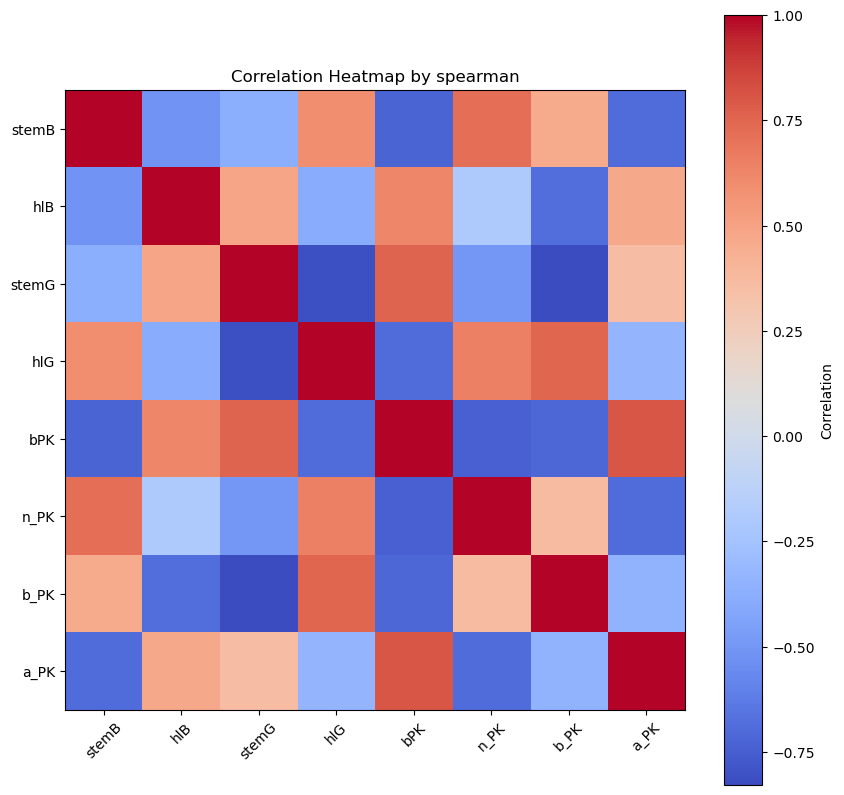

,stemB,hlB,stemG,hlG,bPK,n_PK,b_PK,a_PK
stemB,1.000000,-0.508685,-0.375293,0.590892,-0.721745,0.715406,0.455959,-0.695778
hlB,-0.508685,1.000000,0.481083,-0.387597,0.628107,-0.196848,-0.679091,0.468434
stemG,-0.375293,0.481083,1.000000,-0.814203,0.753505,-0.493642,-0.828788,0.355842
hlG,0.590892,-0.387597,-0.814203,1.000000,-0.699126,0.648469,0.748373,-0.329925
bPK,-0.721745,0.628107,0.753505,-0.699126,1.000000,-0.739113,-0.713770,0.800099
n_PK,0.715406,-0.196848,-0.493642,0.648469,-0.739113,1.000000,0.364476,-0.697278
b_PK,0.455959,-0.679091,-0.828788,0.748373,-0.713770,0.364476,1.000000,-0.344960
a_PK,-0.695778,0.468434,0.355842,-0.329925,0.800099,-0.697278,-0.344960,1.000000


In [18]:
correlation_analysis(df_clean, method="spearman")

In [19]:
df_clean.columns

Index(['name', 'stemB', 'hlB', 'stemG', 'hlG', 'bPK', 'n_PK', 'b_PK', 'a_PK'], dtype='object')

In [25]:
# add stem structure together for further analysis
df_merge = df_clean.copy()
temp_df = df_clean.drop(columns='name').astype(int)
df_merge['beta'] = temp_df['stemB']*2 + temp_df['hlB']
df_merge['gamma'] = temp_df['stemG']*2 + temp_df['hlG']
df_merge['hairpins'] = temp_df['hlB'] + temp_df['hlG']
# df_merge = df_merge[['name', 'I', 'II', 'III', 'HL', 'sum']]
df_merge

,name,stemB,hlB,stemG,hlG,bPK,n_PK,b_PK,a_PK,beta,gamma,hairpins
0,AROAVG,2,4,5,12,2,6,3,3,8,22,16
1,BAGV,5,5,5,12,0,8,3,1,15,22,17
2,BANV,2,5,7,9,3,5,1,3,9,23,14
3,DENV1,1,7,6,9,6,4,0,5,9,21,16
4,DENV2,1,7,6,9,6,4,0,5,9,21,16
5,DENV3,1,7,6,9,6,3,1,5,9,21,16
6,DENV4,2,4,5,10,2,4,3,3,8,20,14
7,JEV,4,4,5,13,0,7,3,1,12,23,17
8,KOKV,2,4,5,10,0,6,3,1,8,20,14
9,KOUV,3,6,5,13,3,6,3,4,12,23,19


Pearson correlation matrix:
          stemB   hlB  stemG   hlG   bPK  n_PK  b_PK  a_PK  beta  gamma  \
stemB      1.00 -0.51  -0.38  0.59 -0.72  0.72  0.46 -0.70  0.86   0.55   
hlB       -0.51  1.00   0.48 -0.39  0.63 -0.20 -0.68  0.47 -0.03  -0.19   
stemG     -0.38  0.48   1.00 -0.81  0.75 -0.49 -0.83  0.36 -0.16  -0.22   
hlG        0.59 -0.39  -0.81  1.00 -0.70  0.65  0.75 -0.33  0.48   0.72   
bPK       -0.72  0.63   0.75 -0.70  1.00 -0.74 -0.71  0.80 -0.49  -0.34   
n_PK       0.72 -0.20  -0.49  0.65 -0.74  1.00  0.36 -0.70  0.70   0.50   
b_PK       0.46 -0.68  -0.83  0.75 -0.71  0.36  1.00 -0.34  0.16   0.35   
a_PK      -0.70  0.47   0.36 -0.33  0.80 -0.70 -0.34  1.00 -0.50  -0.14   
beta       0.86 -0.03  -0.16  0.48 -0.49  0.70  0.16 -0.50  1.00   0.56   
gamma      0.55 -0.19  -0.22  0.72 -0.34  0.50  0.35 -0.14  0.56   1.00   
hairpins   0.30  0.25  -0.53  0.77 -0.31  0.50  0.29  0.01  0.50   0.60   

          hairpins  
stemB         0.30  
hlB           0.25  
stemG   

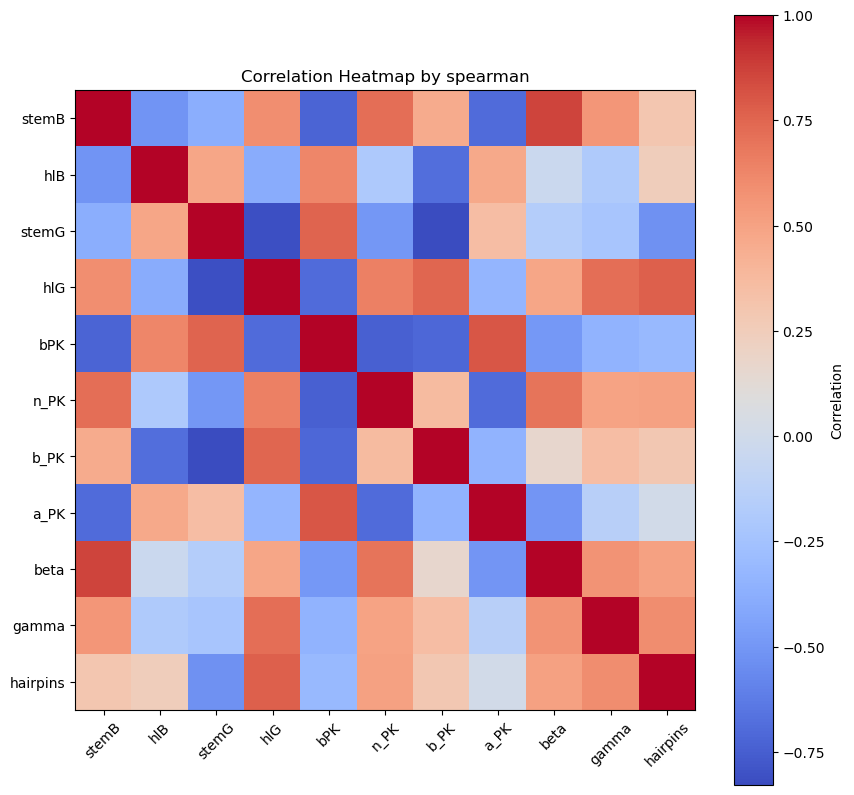

In [26]:
all_corr = correlation_analysis(df_merge, method="spearman")

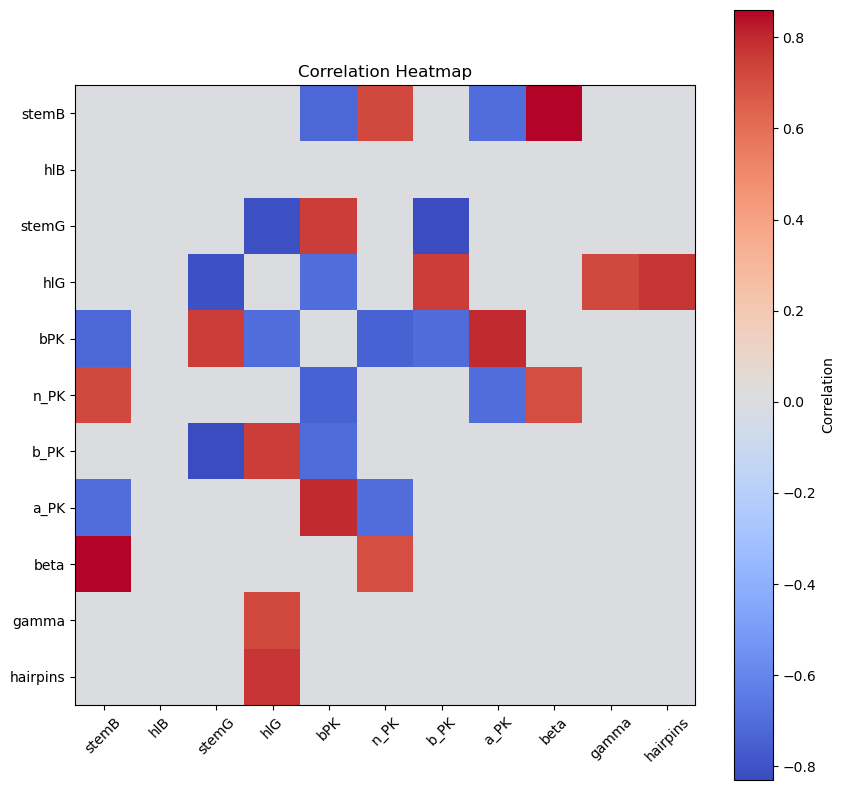

[[ 0.    0.    0.    0.   -0.72  0.72  0.   -0.7   0.86  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.81  0.75  0.   -0.83  0.    0.    0.    0.  ]
 [ 0.    0.   -0.81  0.   -0.7   0.    0.75  0.    0.    0.72  0.77]
 [-0.72  0.    0.75 -0.7   0.   -0.74 -0.71  0.8   0.    0.    0.  ]
 [ 0.72  0.    0.    0.   -0.74  0.    0.   -0.7   0.7   0.    0.  ]
 [ 0.    0.   -0.83  0.75 -0.71  0.    0.    0.    0.    0.    0.  ]
 [-0.7   0.    0.    0.    0.8  -0.7   0.    0.    0.    0.    0.  ]
 [ 0.86  0.    0.    0.    0.    0.7   0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.72  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.77  0.    0.    0.    0.    0.    0.    0.  ]]


In [27]:
import numpy as np
corr_np = all_corr.to_numpy()
corr_np = np.round(corr_np, 2)
np.fill_diagonal(corr_np, 0)
threshold = 0.7
corr_np[(corr_np > -threshold) & (corr_np < threshold)] = 0
plt.figure(figsize=(10, 10))
plt.imshow(corr_np, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label=f'Correlation')
plt.xticks(np.arange(len(corr_np)), df_merge.columns[1:], rotation=45)
plt.yticks(np.arange(len(corr_np)), df_merge.columns[1:])
plt.title(f'Correlation Heatmap')
plt.show()
print(corr_np)

<Axes: >

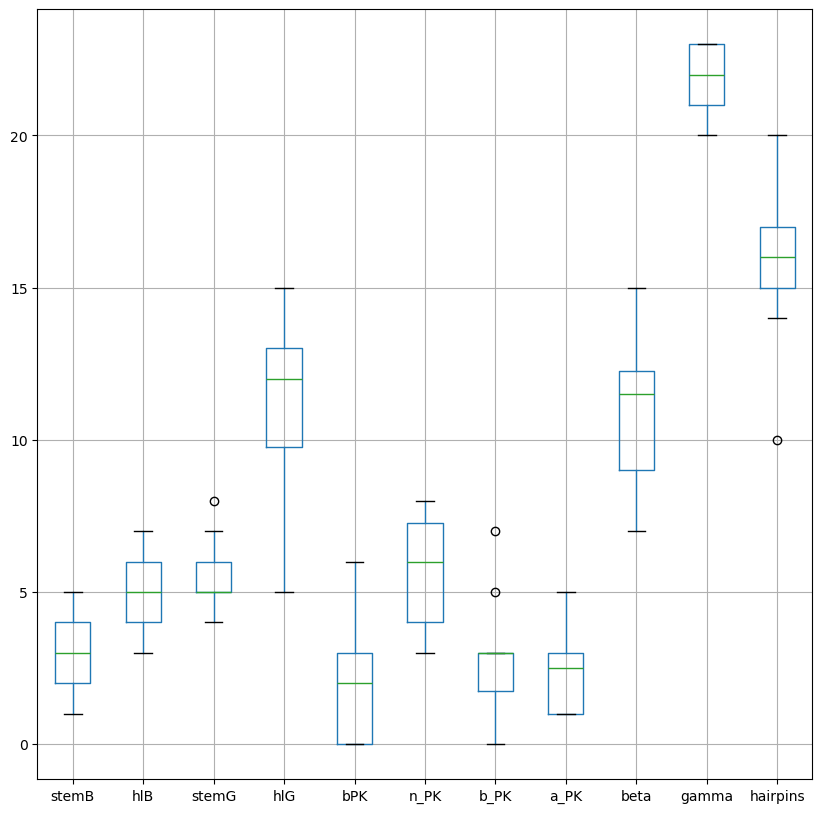

In [28]:
temp_df = df_merge.drop(columns=['name']).astype(int)
plt.figure(figsize=(10, 10))
temp_df.boxplot()
# plt.savefig('xrRNA_analysis_boxplot.png')


In [29]:
temp_df.describe()

,stemB,hlB,stemG,hlG,bPK,n_PK,b_PK,a_PK,beta,gamma,hairpins
count,20.000000,20.000000,20.00000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,2.950000,4.900000,5.40000,11.150000,1.900000,5.80000,2.600000,2.400000,10.800000,21.950000,16.05000
std,1.431782,1.372665,0.88258,2.277464,2.174009,1.67332,1.667018,1.500877,2.419221,1.145931,2.21181
min,1.000000,3.000000,4.00000,5.000000,0.000000,3.00000,0.000000,1.000000,7.000000,20.000000,10.00000
25%,2.000000,4.000000,5.00000,9.750000,0.000000,4.00000,1.750000,1.000000,9.000000,21.000000,15.00000
50%,3.000000,5.000000,5.00000,12.000000,2.000000,6.00000,3.000000,2.500000,11.500000,22.000000,16.00000
75%,4.000000,6.000000,6.00000,13.000000,3.000000,7.25000,3.000000,3.000000,12.250000,23.000000,17.00000
max,5.000000,7.000000,8.00000,15.000000,6.000000,8.00000,7.000000,5.000000,15.000000,23.000000,20.00000


## length distribution

In [1]:
import os
from Bio import AlignIO
import matplotlib.pyplot as plt



In [2]:
stk_folder = '/scr/aldea/kgutenbrunner/data/mbfv_stk/'
stk_files = [stk_folder + file for file in os.listdir(stk_folder) if file.endswith('xrRNA1.stk')]


In [3]:
sequences = []
rfs = []
for stk_file in stk_files:
    align = AlignIO.read(stk_file, "stockholm")
    rfs.append(align.column_annotations['reference_annotation'])
    for record in align:
        sequences.append(str(record.seq))


Text(0, 0.5, 'frequency')

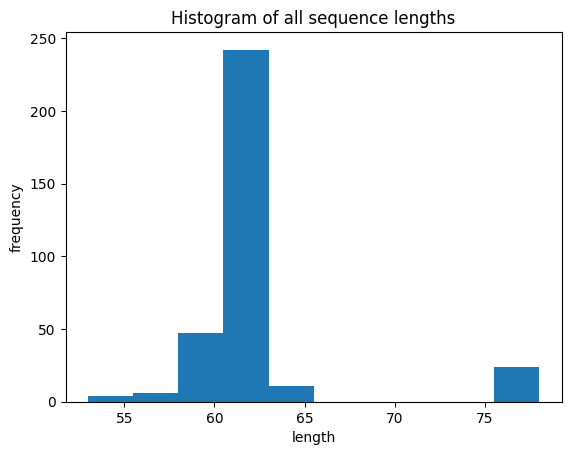

In [4]:
sequence_lengths =[len(seq) for seq in sequences]
plt.hist(sequence_lengths)
plt.title('Histogram of all sequence lengths')
plt.xlabel('length')
plt.ylabel('frequency')

In [6]:
import numpy as np
print(np.min(sequence_lengths))
print(np.max(sequence_lengths))
np.mean(sequence_lengths)

53
78


61.97904191616767

Text(0, 0.5, 'frequency')

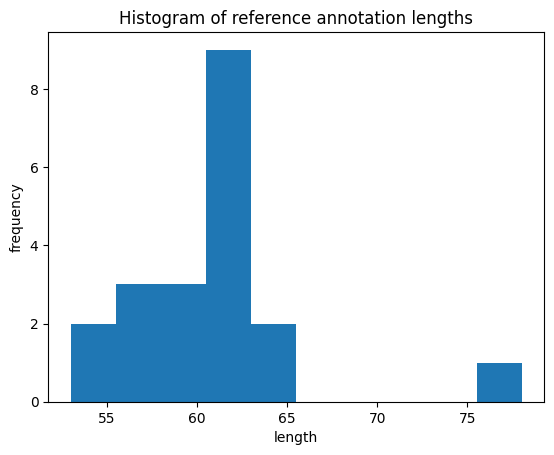

In [9]:
sequence_lengths =[len(seq) for seq in rfs]
plt.hist(sequence_lengths)
plt.title('Histogram of reference annotation lengths')
plt.xlabel('length')
plt.ylabel('frequency')

In [7]:
import RNA

In [9]:
mfes = []
for sequence in sequences:
    fc = RNA.fold_compound(sequence)
    fc.pf()
    (ss, mfe) = fc.mfe()
    mfes.append(mfe)
mfes = np.array(mfes)

In [11]:
print(np.min(mfes))
print(np.max(mfes))
np.mean(mfes)

-30.700000762939453
-7.400000095367432


-17.863173660403955

Text(0, 0.5, 'frequency')

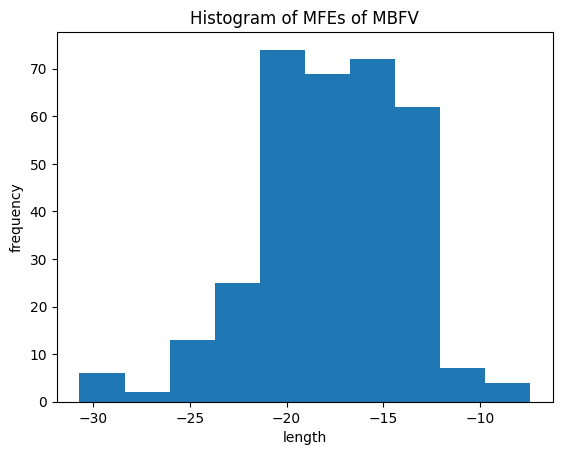

In [42]:
plt.hist(mfes)
plt.title('Histogram of MFEs of MBFV')
plt.xlabel('length')
plt.ylabel('frequency')

## Design MFES

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
design_csv = '/scr/aldea/kgutenbrunner/working/simRNA/MBFV_design/protocol_simRNA_MBFV.txt'

In [27]:
designs = pd.read_csv(design_csv, delimiter=';')

In [33]:
designs

,id,folder_name,seq,date,note
0,0,05_29,AGUCAGGCCCGAC-UUCUCU--GUCGGCCACGAUC-U--------G...,29.05.2024,'first try with MBFV design'
1,2,06_03,UGUCAGCCCCG--GACAA----CGGACACCCC--GACACC-AAA--...,03.06.2024,'MBFV testing with denis iupac - middle beta s...
2,3,06_04,UGUCAGCCCC---GAAAAA----GGACACCC---AUU----AGA--...,04.06.2024,'MBFV testing with denis iupac - short beta st...
3,1,06_05,UGUCAGGCCCGC-UUCAAU--GCGGACACC----C------UAAA-...,05.06.2024,'MBFV testing - long beta stem (4)'
4,4,06_12,UUCGCCGCCC---GAUGCUA---GGAGGGGUGCGGUUCGU-AUA--...,12.06.2024,'MBFV without any constraints only'
5,5,06_13,UUUGGGGCGCGACAACUUGAGUCGCCGAUCCUC-ACUCA--AAAA-...,13.06.2024,'MBFV without any constraints except the base ...
6,6,06_14,UUUGCGCCGCUCCGACA---GGAGCCGAGUC---AC-----UGA--...,14.06.2024,'MBFV without any constraints except the base ...
7,7,06_15,UGUCAGGCCCUGGGCUCA--CCAGGACACGG---GACA---AGA--...,15.06.2024,'MBFV with iupac constraints except no conserv...
8,8,06_16,UUCGCGCCGGGC-UGUU----GCCCAGGAGCC--AGA----AGG--...,16.06.2024,'MBFV with no iupac constraints except no cons...
9,9,06_17,AGUCAGGC-----------------CCACGUC---------ACCC-...,17.06.2024,'MBFV without beta stem and normal iupac const...


In [38]:
design_mfes = []
for seq in designs['seq']:
    seq = seq.replace('-', '')
    fc = RNA.fold_compound(seq)
    fc.pf()
    (ss, mfe) = fc.mfe()
    design_mfes.append(mfe)
design_mfes = np.array(design_mfes)

In [39]:
print(np.min(design_mfes))
print(np.max(design_mfes))
np.mean(design_mfes)

-27.899999618530273
-15.699999809265137


-22.337500035762787

Text(0, 0.5, 'frequency')

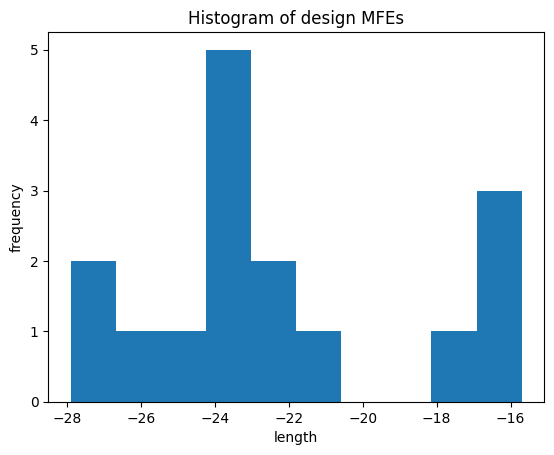

In [41]:
plt.hist(design_mfes)
plt.title('Histogram of design MFEs')
plt.xlabel('length')
plt.ylabel('frequency')